# Setting up the environment

In [1]:
!pip install tensorflow
!pip install opencv-python-headless

  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.9 MB)


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, save_model
import matplotlib.pyplot as plt
import boto3
import cv2
import os

2024-07-22 13:09:08.165826: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-22 13:09:08.194476: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Hyperparameters and Constants

In [3]:
IMG_SIZE = (256, 256)
INPUT_SIZE = (256, 256, 5)
EPOCHS = 20
BATCH_SIZE = 16
bucket_name = 'unetmodel'
s3_train_prefix = 'train/'
s3_val_prefix = 'val/'
local_dir = './dataset'
train_dir = './dataset/train'
val_dir = './dataset/val'
checkpoint_path = 'traffic_speed_unet.keras' # Define the path for saving the best model checkpoint in .keras format
best_model_path = 'traffic_speed_unet.h5'

# Dataset
### Downloading the dataset from S3 bucket

In [4]:
def download_from_s3(bucket_name, s3_key_prefix, local_dir):
    s3 = boto3.client('s3')
    
    # Create local directory if it doesn't exist
    if not os.path.exists(local_dir):
        os.makedirs(local_dir)
    
    # Pagination
    continuation_token = None
    while True:
        if continuation_token:
            response = s3.list_objects_v2(Bucket=bucket_name, Prefix=s3_key_prefix, ContinuationToken=continuation_token)
        else:
            response = s3.list_objects_v2(Bucket=bucket_name, Prefix=s3_key_prefix)
        
        if 'Contents' not in response:
            print("No objects found in the specified bucket and prefix.")
            break
        
        for obj in response['Contents']:
            s3_key = obj['Key']
            # Skip the folder itself
            if s3_key.endswith('/'):
                continue
            
            # Local file path should keep the same structure as in S3
            local_file_path = os.path.join(local_dir, s3_key)
            local_file_dir = os.path.dirname(local_file_path)
            
            # Create directory if it does not exist
            if not os.path.exists(local_file_dir):
                os.makedirs(local_file_dir)
            
            # Download the file
            s3.download_file(bucket_name, s3_key, local_file_path)
            # print(f"Downloaded {s3_key} to {local_file_path}")
        
        # Check if there are more pages
        if 'NextContinuationToken' in response:
            continuation_token = response['NextContinuationToken']
        else:
            break

# download_from_s3(bucket_name, s3_train_prefix, local_dir)
# download_from_s3(bucket_name, s3_val_prefix, local_dir)

## Processing the dataset

In [5]:
def load_and_preprocess_images(base_dir, img_size=IMG_SIZE):
    inputs = []
    labels = []
    
    for folder in sorted(os.listdir(base_dir), key=int):
        folder_path = os.path.join(base_dir, folder)
        input_images = []
        
        # Read and process each of the 5 input images
        for i in range(5):
            img_path = os.path.join(folder_path, f'input_{i}.png')
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                raise ValueError(f"Image not found: {img_path}")
            
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize to [0, 1]
            input_images.append(img)
        
        # Combine 5 images along the channel dimension
        input_images = np.stack(input_images, axis=-1)
        inputs.append(input_images)
        
        # Read and process the label image
        label_img_path = os.path.join(folder_path, 'label.png')
        label_img = cv2.imread(label_img_path, cv2.IMREAD_GRAYSCALE)
        if label_img is None:
            raise ValueError(f"Image not found: {label_img_path}")
        
        label_img = cv2.resize(label_img, img_size)
        label_img = label_img / 255.0  # Normalize to [0, 1]
        labels.append(label_img)
    
    inputs = np.array(inputs)
    labels = np.array(labels)
    
    # Expand dimensions to add the channel axis to labels (required by Keras)
    labels = np.expand_dims(labels, axis=-1)
    
    return tf.stack(inputs), tf.stack(labels)

In [6]:
X_train, y_train = load_and_preprocess_images(train_dir, img_size=IMG_SIZE)
print(f'Train data: {X_train.shape}, {y_train.shape}')

Train data: (1000, 256, 256, 5), (1000, 256, 256, 1)


In [7]:
X_valid, y_valid = load_and_preprocess_images(val_dir, img_size=IMG_SIZE)
print(f'Valid data: {X_valid.shape}, {y_valid.shape}')

Valid data: (289, 256, 256, 5), (289, 256, 256, 1)


In [8]:
def visualize_image(tensor_image):
    # Reverse normalization
    image = tensor_image * 255.0
    image = tf.cast(image, tf.uint8)  # Ensure the image is in uint8 format
    image = image.numpy()  # Convert tensor to NumPy array
    
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

def visualize_combined_image(tensor_image, num_inputs=5):
    # tensor_image has shape (height, width, num_inputs)
    for i in range(num_inputs):
        img = tensor_image[..., i]  # Extract the i-th channel
        visualize_image(img)

# visualize_combined_image(X[0])  # Visualize the first combined input image
# visualize_image(y[0])  # Visualize the first label image


# Building the U-Net Model
## Masked Binary Cross Entropy Loss

In [9]:
@tf.keras.utils.register_keras_serializable()
def masked_bce_loss(y_true, y_pred):
    """
    Calculate the masked binary cross-entropy loss between two image tensors.
    
    Parameters:
    y_true (tf.Tensor): Ground truth image tensor.
    y_pred (tf.Tensor): Predicted image tensor.
    
    Returns:
    tf.Tensor: Masked binary cross-entropy loss.
    """
    # Flatten the images
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    
    # Mask where y_true is greater than zero (ignores background pixels)
    mask = tf.cast(y_true_flat > 0.0, dtype=tf.float32)
    
    # Compute the binary cross-entropy loss without reduction
    bce = tf.keras.losses.BinaryCrossentropy()
    loss = bce(y_true_flat, y_pred_flat)
    
    # Apply the mask
    masked_loss = tf.reduce_sum(loss * mask) / tf.reduce_sum(mask)
    
    return masked_loss

## Encoder and Decoder Blocks

In [10]:
def encoder_block(inputs, n_filters=16, dropout_prob=0.3, max_pooling=True):
    """
    Encoder block with convolutional layers, batch normalization, dropout, and optional max pooling.
    """
    conv = Conv2D(n_filters, 
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    conv = BatchNormalization()(conv, training=False)

    if dropout_prob > 0:     
        conv = Dropout(dropout_prob)(conv)

    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2, 2))(conv)    
    else:
        next_layer = conv

    skip_connection = conv
    return next_layer, skip_connection

In [11]:
def decoder_block(prev_layer_input, skip_layer_input, n_filters=16):
    """
    Decoder block with transpose convolution to upscale the image, followed by merging with skip connection,
    and two convolutional layers.
    """
    up = Conv2DTranspose(
                 n_filters,
                 (3, 3),    # Kernel size
                 strides=(2, 2),
                 padding='same')(prev_layer_input)

    merge = concatenate([up, skip_layer_input], axis=3)
    
    conv = Conv2D(n_filters, 
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

In [12]:
## U-Net Model

In [13]:
def unet_model(input_size=INPUT_SIZE, n_filters=16, n_classes=1):
    inputs = Input(input_size)
    
    # Encoder blocks
    cblock1 = encoder_block(inputs, n_filters, dropout_prob=0, max_pooling=True)
    cblock2 = encoder_block(cblock1[0], n_filters*2, dropout_prob=0, max_pooling=True)
    cblock3 = encoder_block(cblock2[0], n_filters*4, dropout_prob=0, max_pooling=True)
    cblock4 = encoder_block(cblock3[0], n_filters*8, dropout_prob=0.3, max_pooling=True)
    
    # Bottleneck
    cblock5 = encoder_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)
    
    # Decoder blocks
    ublock6 = decoder_block(cblock5[0], cblock4[1], n_filters * 8)
    ublock7 = decoder_block(ublock6, cblock3[1], n_filters * 4)
    ublock8 = decoder_block(ublock7, cblock2[1], n_filters * 2)
    ublock9 = decoder_block(ublock8, cblock1[1], n_filters)
    
    # Final layers
    conv9 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(ublock9)
    conv10 = Conv2D(n_classes, 1, activation='relu', padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model

# Create the model
model = unet_model(input_size=INPUT_SIZE)
model.compile(optimizer='adam', loss=masked_bce_loss, metrics=['accuracy'])
# model.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])

# Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 5)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         736       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d_1[0][0]']            
 Normalization)                                                                               

In [14]:
# Callbacks and Early Stopping
checkpoint = ModelCheckpoint(
    checkpoint_path, 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min'
)
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

## Train the Model

In [15]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint, early_stopping]
)

# Save the best model in .h5 format
model = load_model(checkpoint_path)  # Load the best model saved in .keras format
model.save(best_model_path)  # Save the model in .h5 format

Epoch 1/20
63/63 [==============================] - 55s 826ms/step - loss: 0.0178 - accuracy: 0.9562 - val_loss: 0.0129 - val_accuracy: 0.9637
Epoch 2/20
63/63 [==============================] - 52s 820ms/step - loss: 0.0154 - accuracy: 0.9562 - val_loss: 0.0126 - val_accuracy: 0.9637
Epoch 3/20
63/63 [==============================] - 52s 821ms/step - loss: 0.0150 - accuracy: 0.9562 - val_loss: 0.0123 - val_accuracy: 0.9637
Epoch 4/20
63/63 [==============================] - 51s 818ms/step - loss: 0.0148 - accuracy: 0.9562 - val_loss: 0.0121 - val_accuracy: 0.9637
Epoch 5/20
63/63 [==============================] - 52s 819ms/step - loss: 0.0148 - accuracy: 0.9562 - val_loss: 0.0121 - val_accuracy: 0.9637
Epoch 6/20
63/63 [==============================] - 52s 820ms/step - loss: 0.0147 - accuracy: 0.9562 - val_loss: 0.0121 - val_accuracy: 0.9637
Epoch 7/20
63/63 [==============================] - 52s 820ms/step - loss: 0.0146 - accuracy: 0.9562 - val_loss: 0.0120 - val_accuracy: 0.9637

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Evaluate the model

In [16]:
# Evaluate the model
val_loss, val_acc = model.evaluate(X_valid, y_valid)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

10/10 [==============================] - 4s 404ms/step - loss: 0.0119 - accuracy: 0.9637
Validation Loss: 0.011924544349312782, Validation Accuracy: 0.9637365341186523


In [17]:
predictions = model.predict(X_valid)

10/10 [==============================] - 4s 398ms/step


## Visualize the prediction from the model

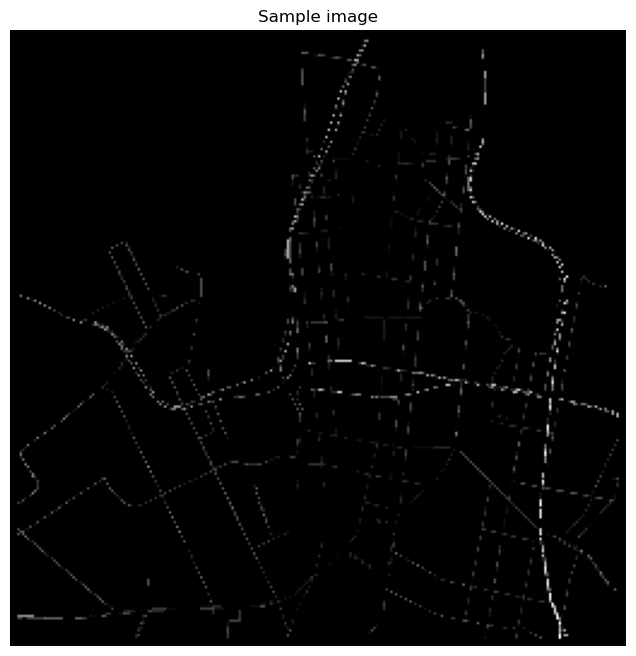

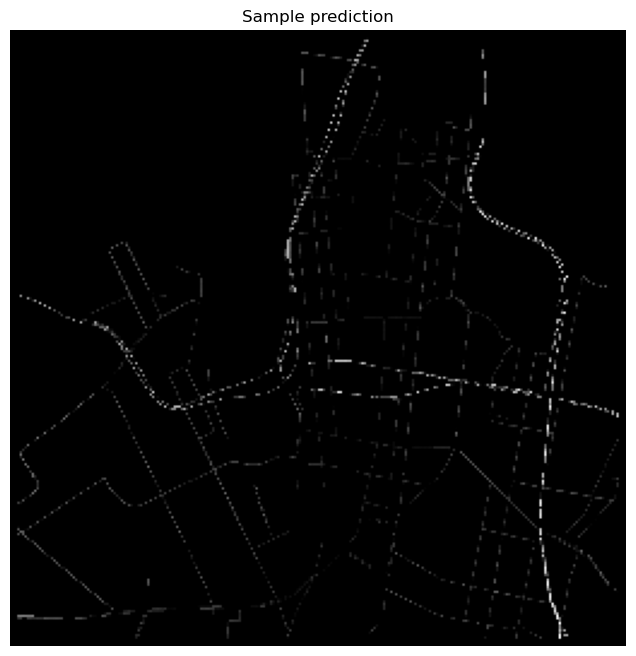

In [18]:
def visualize_image(tensor_image):
    """
    Visualizes an image represented as a tensor.
    
    Parameters:
    - tensor_image: Tensor representing the image.
    """

    # Reverse normalization
    image = tensor_image * 255.0
    image = tf.cast(image, tf.uint8)  # Ensure the image is in uint8 format
    image = image.numpy()  # Convert tensor to NumPy array
    
    # Display the image
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    plt.title('Sample image')
    plt.axis('off')
    plt.show()

def visualize_image_from_array(image_array, title='Sample prediction', is_scaled=True):
    """
    Visualizes an image represented as a NumPy array.
    
    Parameters:
    - image_array: NumPy array representing the image.
    - title: Title for the image plot.
    - is_scaled: Boolean indicating if the image values are scaled between 0 and 1.
    """

    # Convert grayscale image from shape (H, W, 1) to (H, W)
    image_array = np.squeeze(image_array, axis=-1)
    
    # Reverse normalization
    if is_scaled:
        image_array = (image_array * 255).astype(np.uint8)
    
    # Display the image
    plt.figure(figsize=(8, 8))
    plt.imshow(image_array, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

visualize_image(y_valid[0])
visualize_image_from_array(predictions[0])